<a href="https://colab.research.google.com/github/d823944/ML100-Days/blob/master/Homework/Day084_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Work**    
請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
# Check GPU
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [2]:
import os
import keras
import itertools

Using TensorFlow backend.


In [3]:
train, test = keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 28s 0us/step


In [0]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [0]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [0]:
# Hint 1 : 在 Dense 層中增加 Regularizers
# Hint 2 : 增加 Dropout 層並設定 dropout ratio 
# Hint 3 : 增加 Batch-normalization 層
from keras.regularizers import l1_l2

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_alpha=0.01, l2_alpha=0.01, drp_ratio=0.2):
    input_layer = keras.layers.Input(input_shape)
    x = keras.layers.BatchNormalization()(input_layer)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu",
                                   kernel_regularizer=l1_l2(l1=l1_alpha, l2=l2_alpha))(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu",
                                   kernel_regularizer=l1_l2(l1=l1_alpha, l2=l2_alpha))(x)
        x = keras.layers.Dropout(drp_ratio)(x)
        x = keras.layers.BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [0]:
## 超參數設定
"""
Set your hyper-parameters
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = [512]
MOMENTUM = 0.95

In [18]:
results = {}
"""
Write your training loop and record results
"""
for batch_size in BATCH_SIZE:
    model = build_mlp(input_shape=x_train.shape[1:], output_units=10,
                      num_neurons=[512, 256, 128],
                      l1_alpha=0.001, l2_alpha=0.001, drp_ratio=0.2)
    model.summary()
    model.compile(optimizer='adam',
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=batch_size, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = f"batch_size_{batch_size}"
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 3072)              12288     
_________________________________________________________________
dense_4 (Dense)              (None, 512)               1573376   
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 512)               2048      
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
__________

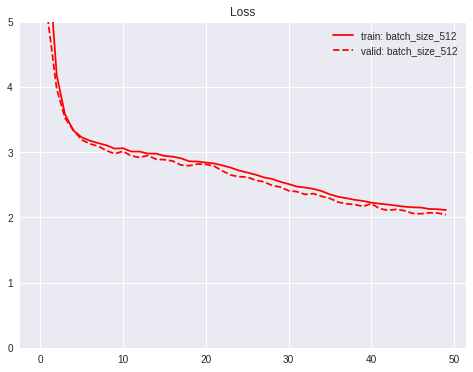

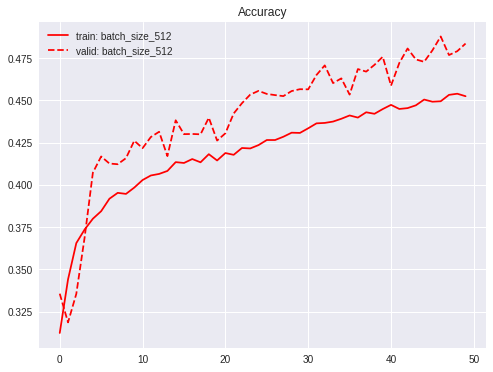

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=f"train: {cond}", color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=f"valid: {cond}", color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=f"train: {cond}", color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=f"valid: {cond}", color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()